In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import numpy as np
import cmocean.cm as cmo
from xgcm import Grid
import matplotlib.gridspec as gridspec

In [2]:
from distributed import Client, progress, LocalCluster
import socket

client = Client(service_kwargs={'dashboard': {'prefix': f'/node/{socket.gethostname()}/8787'}})
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32975,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:22379,Total threads: 1
Dashboard: http://127.0.0.1:28353/status,Memory: 56.00 GiB
Nanny: tcp://127.0.0.1:11069,


In [3]:



def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)


     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False, 
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    })
    return gridOut

In [4]:
def load_roms(filename,overlap):
    chunks = {'ocean_time': 1}
    glb_files = sorted(glob(filename))
    
    def preprocessRemoveOverlap(ds):
        '''remove the overlap from each file'''
        return ds.isel(ocean_time = slice(0,-overlap))

    for files in glb_files: 
        print(files)
        
    ds = xr.open_mfdataset(glb_files, chunks=chunks, preprocess=preprocessRemoveOverlap, data_vars='minimal', compat='override', coords='minimal', parallel=False, join='right')
    print('Loading data: OK!')
    return ds


# grid.transform(ds.temp.mean(dim='ocean_time'), 'Z', np.array([-500]),target_data=ds.z_rho0,method='linear').squeeze()

In [5]:
enoi = load_roms(filename='/srv/scratch/z3097808/forecasts_EnOI_TRADobs/output/eac_his_04811.nc',overlap=19)
_4dvar = load_roms(filename='/srv/scratch/z3533092/assimilation_newV2017_traditionalobs/ocean_fwd_001_04367.nc',overlap=7)





/srv/scratch/z3097808/forecasts_EnOI_TRADobs/output/eac_his_04811.nc
Loading data: OK!
/srv/scratch/z3533092/assimilation_newV2017_traditionalobs/ocean_fwd_001_04367.nc
Loading data: OK!


In [6]:
enoi = processROMSGrid(enoi)
grid = makeROMSGridObject(enoi)

_4dvar = processROMSGrid(_4dvar)
grid_4dvar = makeROMSGridObject(_4dvar)

#### data prep

In [7]:
# def process_trimVarsROMS(input,varsKeep):
#     output_backup = input
#     output = input[varsKeep]
#     return output,output_backup


# enoi = load_roms(filename='/srv/scratch/z3097808/forecasts_EnOI_TRADobs/output/eac_his_*.nc',overlap=19)
# _4dvar = load_roms(filename='/srv/scratch/z3533092/assimilation_newV2017_traditionalobs/ocean_fwd_001_*.nc',overlap=7)

# print('process grid')
# enoi = processROMSGrid(enoi)
# _4dvar = processROMSGrid(_4dvar)

# print('drop almost all vars')
# enoi,enoi_bu = process_trimVarsROMS(enoi,['v','z_rho0'])
# _4dvar,_4dvar_bu = process_trimVarsROMS(_4dvar,['v','z_rho0'])
# enoi = enoi.drop('z_rho')
# _4dvar = _4dvar.drop('z_rho')



In [8]:

# print('subset dataset')
# enoi_28 = enoi.isel(eta_v=260)
# enoi_34 = enoi.isel(eta_v=115)

# _4dvar_28 = _4dvar.isel(eta_v=260)
# _4dvar_34 = _4dvar.isel(eta_v=115)


In [47]:
#### load datasets from netcdf


enoi_28 = xr.open_dataset('../data/proc/enoi_28.nc')
enoi_34 = xr.open_dataset('../data/proc/enoi_34.nc')

_4dvar_28 = xr.open_dataset('../data/proc/4dvar_28.nc')
_4dvar_34 = xr.open_dataset('../data/proc/4dvar_34.nc')

In [48]:
#### load datasets
print('load first transect')
print(enoi_28.nbytes/1e9)
enoi_28.load()
print('load second transect')
print(enoi_34.nbytes/1e9)
enoi_34.load()


enoi_28["z_rho0"] = enoi_28.z_rho0.fillna(0)
enoi_34["z_rho0"] = enoi_34.z_rho0.fillna(0)

#### load datasets
print('load first transect')
print(_4dvar_28.nbytes/1e9)
_4dvar_28.load()
print('load second transect')
print(_4dvar_34.nbytes/1e9)
_4dvar_34.load()


_4dvar_28["z_rho0"] = _4dvar_28.z_rho0.fillna(0)
_4dvar_34["z_rho0"] = _4dvar_34.z_rho0.fillna(0)




load first transect
0.309606288
load second transect
0.309606288
load first transect
0.294720624
load second transect
0.294720624


In [49]:
enoi_28

<xarray.Dataset>
Dimensions:     (ocean_time: 4404, s_rho: 30, xi_rho: 272, eta_rho: 317)
Coordinates:
    z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.491 -1.043
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
    lon_v       (xi_rho) float64 151.9 151.9 152.0 152.0 ... 161.4 161.4 161.5
    lat_v       (xi_rho) float64 -27.47 -27.48 -27.49 ... -30.48 -30.5 -30.51
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-20 ... 2013-12-22T20:00:00
Dimensions without coordinates: xi_rho, eta_rho
Data variables:
    v           (ocean_time, s_rho, xi_rho) float64 nan nan ... -0.3259 -0.1214
Attributes: (12/28)
    file:              eac_his.nc
    format:            netCDF-3 classic file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    rst_file:          eac_rst.nc
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -heap-arrays -fp-model precise -ip -O3 -free -free
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.4, Tuesday - September 15, 2020 -...
    ana_file:          /home/561/cgk561/eac/forecasts_EnOI_TRADobs/include/an...
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [50]:
# fix vertical coordinates
etaTransect=260

enoi_28["z_v0"] = grid.interp(enoi_28.z_rho0,'Y').isel(eta_v=etaTransect)
_4dvar_28["z_v0"] = grid.interp(_4dvar_28.z_rho0,'Y').isel(eta_v=etaTransect)
enoi_28 = enoi_28.set_coords('z_v0')
_4dvar_28 = _4dvar_28.set_coords('z_v0')

etaTransect=115
enoi_34["z_v0"] = grid.interp(enoi_34.z_rho0,'Y').isel(eta_v=etaTransect)
_4dvar_34["z_v0"] = grid.interp(_4dvar_34.z_rho0,'Y').isel(eta_v=etaTransect)
enoi_34 = enoi_34.set_coords('z_v0')
_4dvar_34 = _4dvar_34.set_coords('z_v0')


In [51]:
enoi_28

<xarray.Dataset>
Dimensions:     (ocean_time: 4404, s_rho: 30, xi_rho: 272, eta_rho: 317)
Coordinates:
    z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.491 -1.043
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
    lon_v       (xi_rho) float64 151.9 151.9 152.0 152.0 ... 161.4 161.4 161.5
    lat_v       (xi_rho) float64 -27.47 -27.48 -27.49 ... -30.48 -30.5 -30.51
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-20 ... 2013-12-22T20:00:00
    z_v0        (xi_rho, s_rho) float64 0.0 0.0 0.0 0.0 ... -8.193 -4.31 -0.959
Dimensions without coordinates: xi_rho, eta_rho
Data variables:
    v           (ocean_time, s_rho, xi_rho) float64 nan nan ... -0.3259 -0.1214
Attributes: (12/28)
    file:              eac_his.nc
    format:            netCDF-3 classic file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    rst_file:          eac_rst.nc
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -heap-arrays -fp-model precise -ip -O3 -free -free
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.4, Tuesday - September 15, 2020 -...
    ana_file:          /home/561/cgk561/eac/forecasts_EnOI_TRADobs/include/an...
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

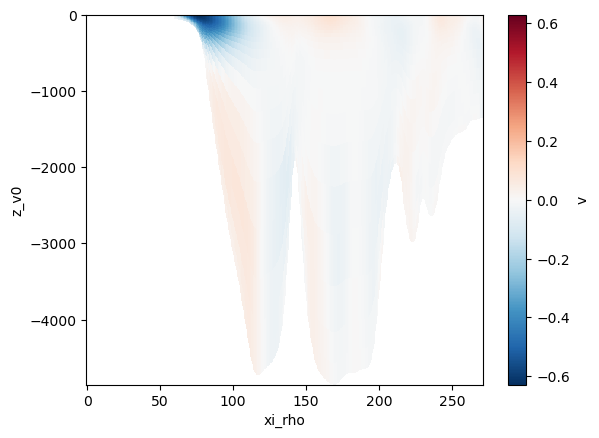

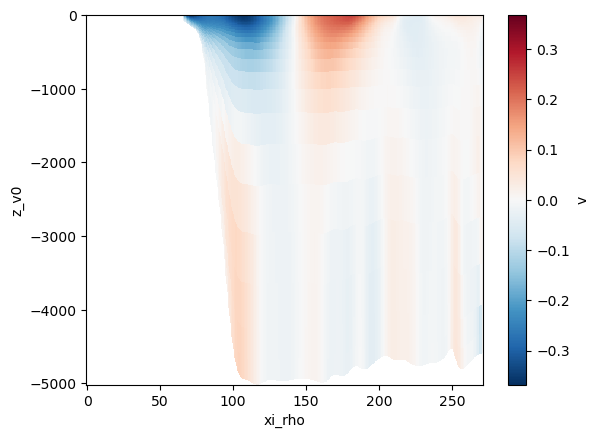

In [53]:
enoi_28.v.mean(dim='ocean_time').plot(y='z_v0')
plt.show()
enoi_34.v.mean(dim='ocean_time').plot(y='z_v0')




In [142]:
### filter singals

enoi_28_lp = enoi_28.v.rolling(ocean_time=12, center=True).mean()
enoi_28_hp = enoi_28.v - enoi_28_lp


enoi_34_lp = enoi_34.v.rolling(ocean_time=12, center=True).mean()
enoi_34_hp = enoi_34.v - enoi_34_lp



_4dvar_28_lp = _4dvar_28.v.rolling(ocean_time=12, center=True).mean()
_4dvar_28_hp = _4dvar_28.v - _4dvar_28_lp


_4dvar_34_lp = _4dvar_34.v.rolling(ocean_time=12, center=True).mean()
_4dvar_34_hp = _4dvar_34.v - _4dvar_34_lp





<xarray.DataArray 'ocean_time' ()>
array(-158400000000000, dtype='timedelta64[ns]')

<Figure size 640x480 with 0 Axes>

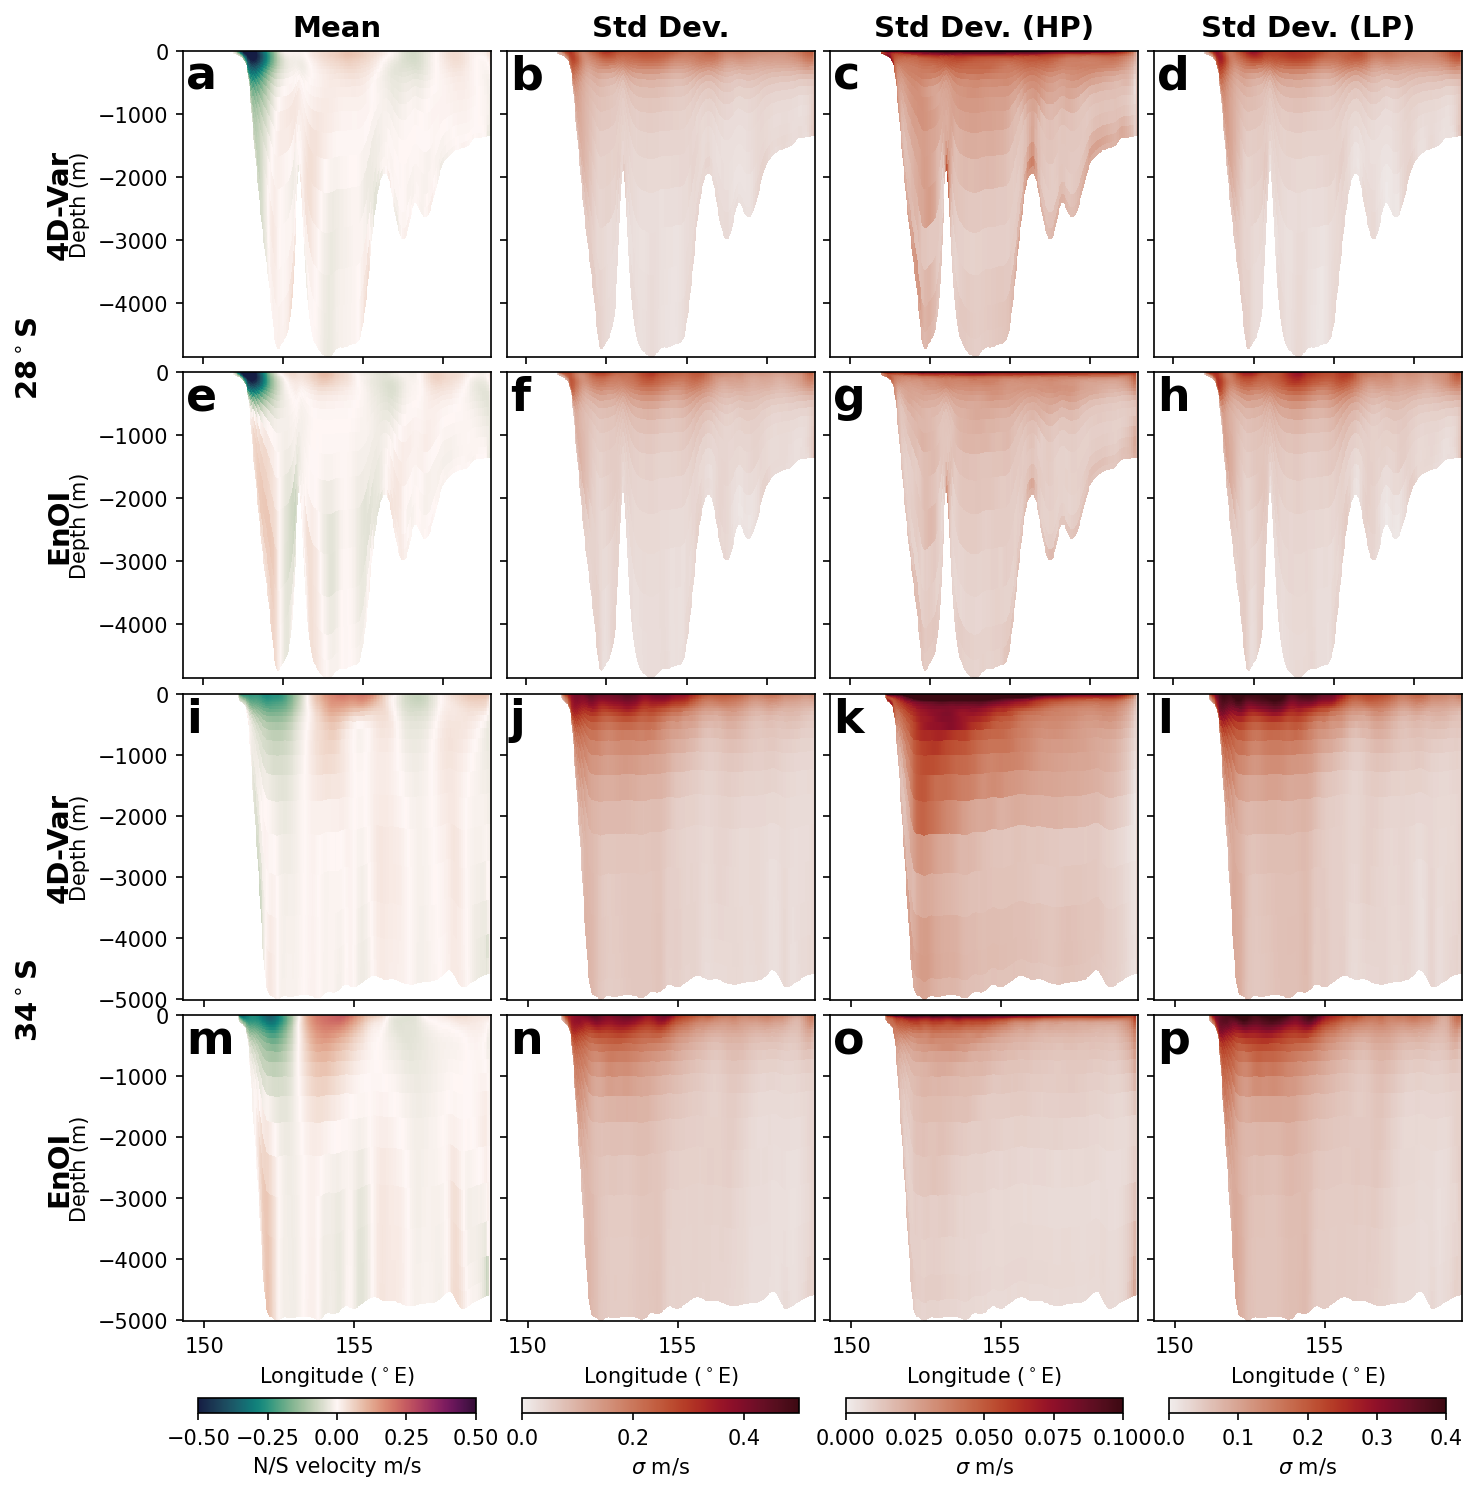

In [143]:



def addSubplot_spatialMap(input,pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_v,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.set_title('')
    return gl,im



def addInsetColormap(ax,im,lab):
    cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax) 
    cbar.set_label(lab)


# gs to make a 4 row, 7 col plot

plt.cla()
plt.clf()
fig = plt.figure(figsize=[11,11],dpi=150)
ax = None

gs = fig.add_gridspec(nrows=4,ncols=4,wspace=0.05, hspace=0.05)

# gs00 = gs0[0].subgridspec(2, 2,wspace=0.05, hspace=0.05)
# gs01 = gs0[1].subgridspec(1, 1)

cax_mn = (-.5,.5)
cax_std = (0,.5)
cax_std_hp = (0,.1)
cax_std_lp = (0,.4)


###############
ax = fig.add_subplot(gs[0,0])
_4dvar_28.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=cax_mn[0],vmax=cax_mn[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.5, 0, '28$^\circ$S',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(-.4, .5, '4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,1])
_4dvar_28.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std[0],vmax=cax_std[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax = fig.add_subplot(gs[0,2])
_4dvar_28_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_hp[0],vmax=cax_std_hp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,3])
_4dvar_28_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_lp[0],vmax=cax_std_lp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)



###############
ax = fig.add_subplot(gs[1,0])
enoi_28.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=cax_mn[0],vmax=cax_mn[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.4, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,1])
enoi_28.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std[0],vmax=cax_std[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax = fig.add_subplot(gs[1,2])
enoi_28_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_hp[0],vmax=cax_std_hp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,3])
enoi_28_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_lp[0],vmax=cax_std_lp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)




##############
ax = fig.add_subplot(gs[2,0])
_4dvar_34.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=cax_mn[0],vmax=cax_mn[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.text(0.01, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.5, 0, '34$^\circ$S',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(-.4, .5, '4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[2,1])
_4dvar_34.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std[0],vmax=cax_std[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[2,2])
_4dvar_34_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_hp[0],vmax=cax_std_hp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'k', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[2,3])
_4dvar_34_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_lp[0],vmax=cax_std_lp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'l', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)







##############
ax = fig.add_subplot(gs[3,0])
im=enoi_34.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=cax_mn[0],vmax=cax_mn[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.text(0.01, 0.99, 'm', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.4, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.3, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.set_label('N/S velocity m/s')


ax = fig.add_subplot(gs[3,1])
im=enoi_34.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std[0],vmax=cax_std[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'n', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.3, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.set_label('$\sigma$ m/s')

ax = fig.add_subplot(gs[3,2])
im=enoi_34_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_hp[0],vmax=cax_std_hp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'o', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.3, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.set_label('$\sigma$ m/s')

ax = fig.add_subplot(gs[3,3])
im=enoi_34_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_lp[0],vmax=cax_std_lp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'p', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.3, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.set_label('$\sigma$ m/s')




In [144]:
#make differences
diff_28_mn = _4dvar_28.mean(dim='ocean_time')-enoi_28.mean(dim='ocean_time')
diff_34_mn = _4dvar_34.mean(dim='ocean_time')-enoi_34.mean(dim='ocean_time')

diff_28_std = _4dvar_28.std(dim='ocean_time')-enoi_28.std(dim='ocean_time')
diff_34_std = _4dvar_34.std(dim='ocean_time')-enoi_34.std(dim='ocean_time')

diff_28_lp = _4dvar_28_lp.std(dim='ocean_time')-enoi_28_lp.std(dim='ocean_time')
diff_28_hp = _4dvar_28_hp.std(dim='ocean_time')-enoi_28_hp.std(dim='ocean_time')
diff_34_lp = _4dvar_34_lp.std(dim='ocean_time')-enoi_34_lp.std(dim='ocean_time')
diff_34_hp = _4dvar_34_hp.std(dim='ocean_time')-enoi_34_hp.std(dim='ocean_time')

In [145]:
diff_28_mn['z_v0']=enoi_28.z_v0
diff_28_mn = diff_28_mn.set_coords('z_v0')
diff_28_std['z_v0']=enoi_28.z_v0
diff_28_std = diff_28_std.set_coords('z_v0')
diff_28_lp['z_v0']=enoi_28.z_v0
# diff_28_lp = diff_28_lp.set_coords('z_v0')
diff_28_hp['z_v0']=enoi_28.z_v0
# diff_28_hp = diff_28_hp.set_coords('z_v0')

diff_34_mn['z_v0']=enoi_34.z_v0
diff_34_mn = diff_34_mn.set_coords('z_v0')
diff_34_std['z_v0']=enoi_34.z_v0
diff_34_std = diff_34_std.set_coords('z_v0')
diff_34_lp['z_v0']=enoi_34.z_v0
# diff_34_lp = diff_34_lp.set_coords('z_v0')
diff_34_hp['z_v0']=enoi_34.z_v0
# diff_34_hp = diff_34_hp.set_coords('z_v0')

<Figure size 640x480 with 0 Axes>

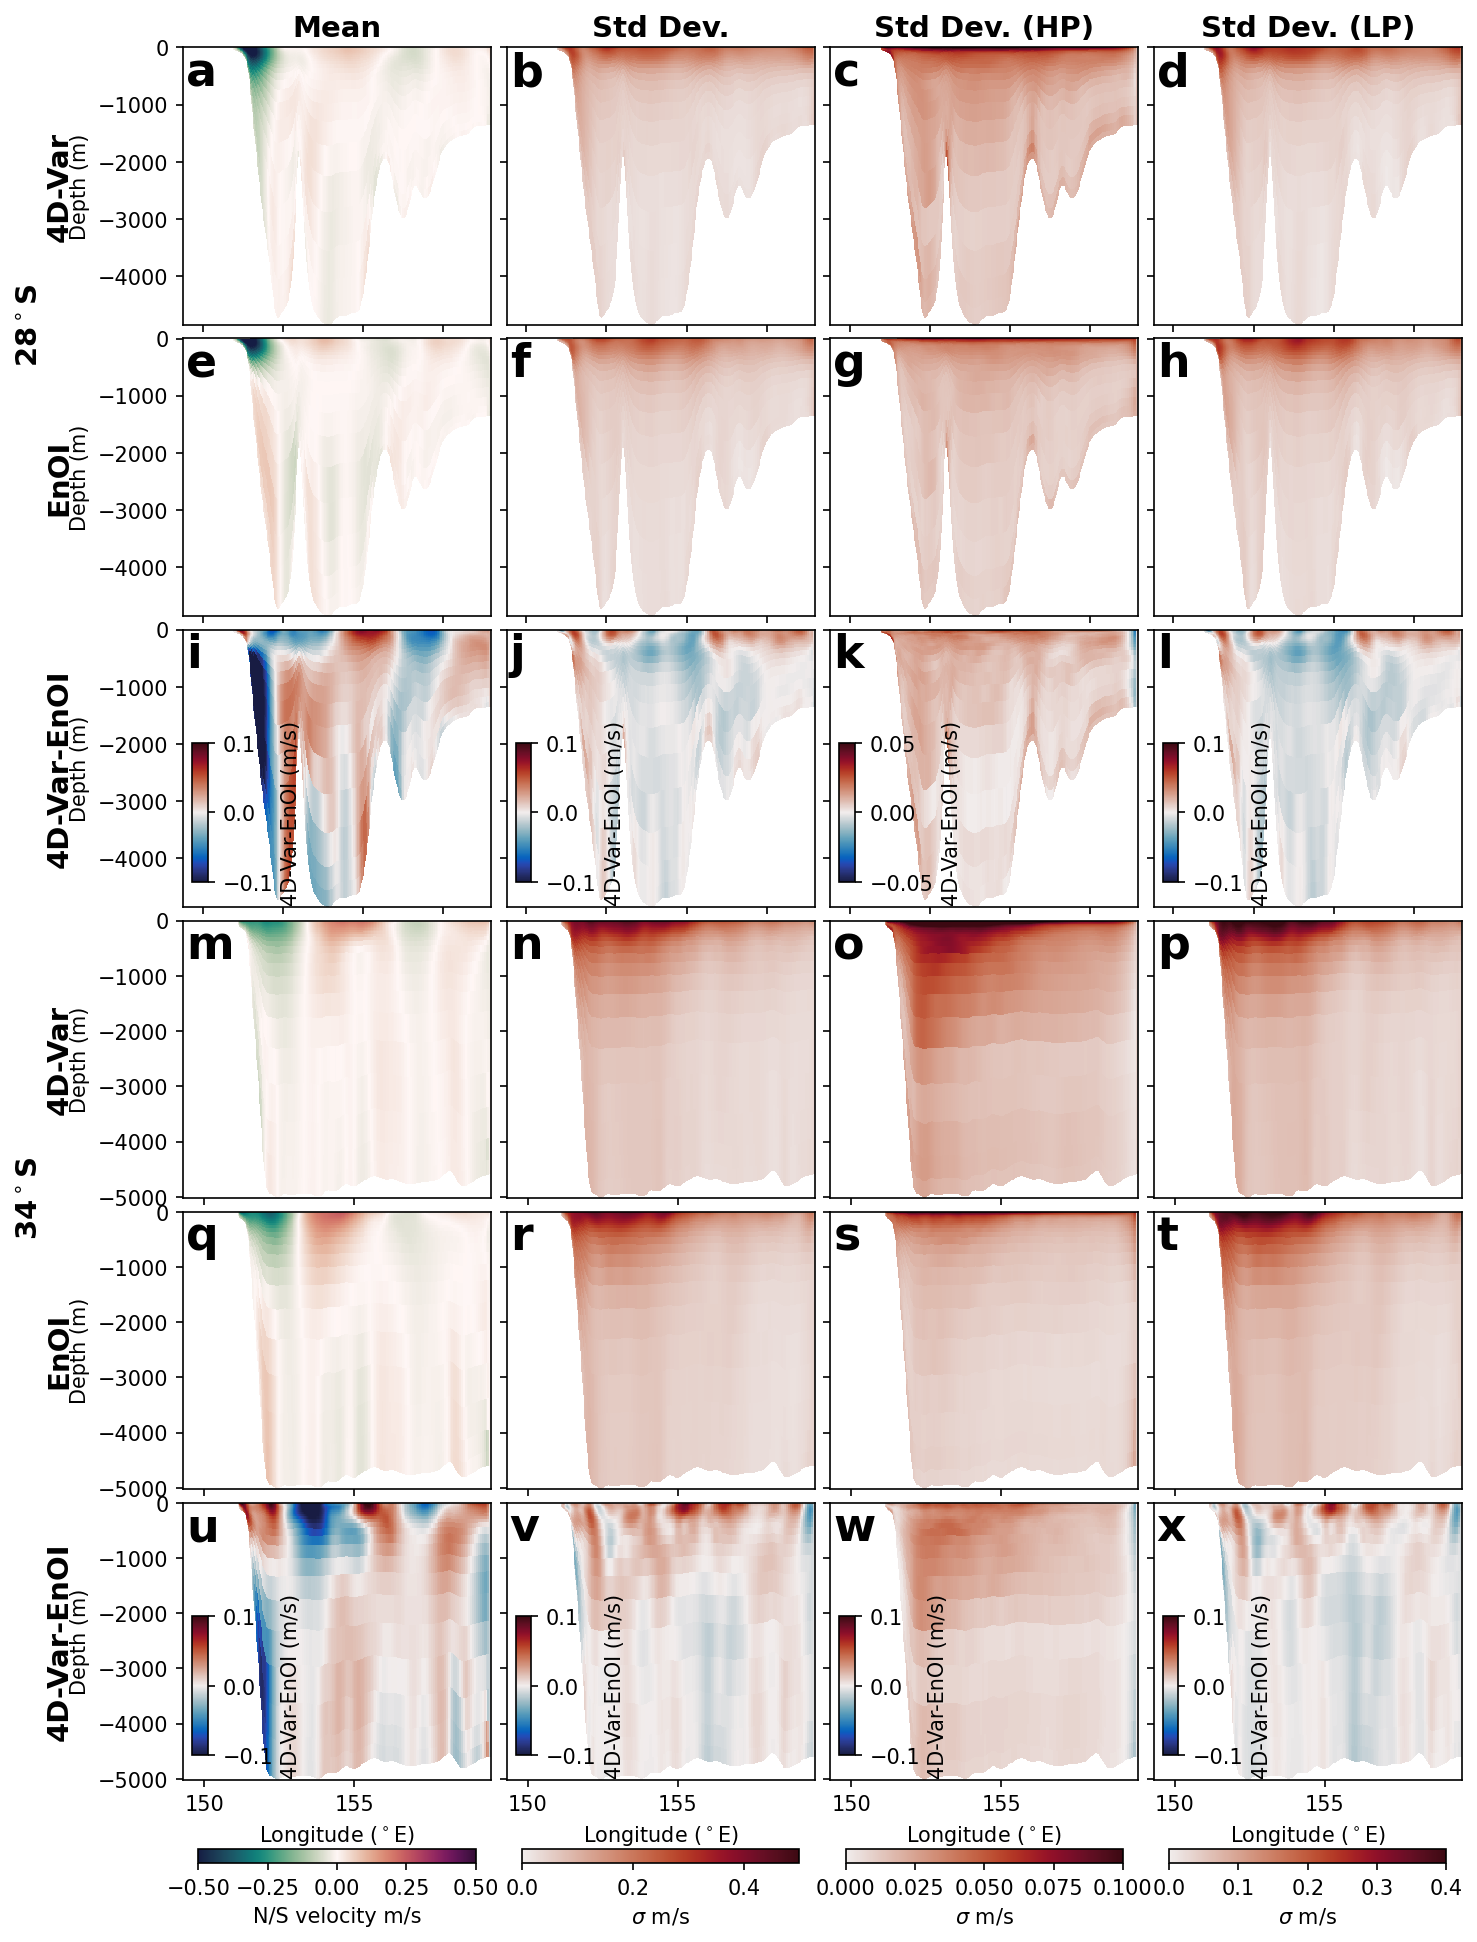

In [151]:



def addSubplot_spatialMap(input,pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_v,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.set_title('')
    return gl,im



def addInsetColormap(ax,im,lab):
    cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,.09, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax) 
    cbar.set_label(lab)


# gs to make a 4 row, 7 col plot

plt.cla()
plt.clf()
fig = plt.figure(figsize=[11,15],dpi=150)
ax = None

gs = fig.add_gridspec(nrows=6,ncols=4,wspace=0.05, hspace=0.05)

# gs00 = gs0[0].subgridspec(2, 2,wspace=0.05, hspace=0.05)
# gs01 = gs0[1].subgridspec(1, 1)

cax_mn = (-.5,.5)
cax_std = (0,.5)
cax_std_hp = (0,.1)
cax_std_lp = (0,.4)


###############
ax = fig.add_subplot(gs[0,0])
_4dvar_28.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=cax_mn[0],vmax=cax_mn[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.5, 0, '28$^\circ$S',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(-.4, .5, '4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,1])
_4dvar_28.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std[0],vmax=cax_std[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax = fig.add_subplot(gs[0,2])
_4dvar_28_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_hp[0],vmax=cax_std_hp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,3])
_4dvar_28_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_lp[0],vmax=cax_std_lp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)



###############
ax = fig.add_subplot(gs[1,0])
enoi_28.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=cax_mn[0],vmax=cax_mn[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.4, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,1])
enoi_28.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std[0],vmax=cax_std[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax = fig.add_subplot(gs[1,2])
enoi_28_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_hp[0],vmax=cax_std_hp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,3])
enoi_28_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_lp[0],vmax=cax_std_lp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


###############
ax = fig.add_subplot(gs[2,0])
im=diff_28_mn.v.plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-.1,vmax=.1, add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.4, .5, '4D-Var-EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'4D-Var-EnOI (m/s)')

ax = fig.add_subplot(gs[2,1])
im=(diff_28_std.v).plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-.1,vmax=.1, add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
addInsetColormap(ax,im,'4D-Var-EnOI (m/s)')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax = fig.add_subplot(gs[2,2])
im=(diff_28_hp).plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-.05,vmax=.05, add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'k', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
addInsetColormap(ax,im,'4D-Var-EnOI (m/s)')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[2,3])
im=(diff_28_lp).plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-.1,vmax=.1, add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'l', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
addInsetColormap(ax,im,'4D-Var-EnOI (m/s)')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)



##############
ax = fig.add_subplot(gs[3,0])
_4dvar_34.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=cax_mn[0],vmax=cax_mn[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.text(0.01, 0.99, 'm', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.5, 0, '34$^\circ$S',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(-.4, .5, '4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[3,1])
_4dvar_34.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std[0],vmax=cax_std[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'n', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[3,2])
_4dvar_34_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_hp[0],vmax=cax_std_hp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.text(0.01, 0.99, 'o', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[3,3])
_4dvar_34_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_lp[0],vmax=cax_std_lp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'p', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)







##############
ax = fig.add_subplot(gs[4,0])
im1=enoi_34.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=cax_mn[0],vmax=cax_mn[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.text(0.01, 0.99, 'q', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.4, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax = fig.add_subplot(gs[4,1])
im2=enoi_34.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std[0],vmax=cax_std[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'r', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax = fig.add_subplot(gs[4,2])
im3=enoi_34_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_hp[0],vmax=cax_std_hp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 's', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax = fig.add_subplot(gs[4,3])
im4=enoi_34_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=cax_std_lp[0],vmax=cax_std_lp[1], add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 't', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)



###############
ax = fig.add_subplot(gs[5,0])
im=diff_34_mn.v.plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-.1,vmax=.1, add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.text(0.01, 0.99, 'u', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.4, .5, '4D-Var-EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'4D-Var-EnOI (m/s)')
cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.3, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im1, cax=cax, orientation='horizontal') 
cbar.set_label('N/S velocity m/s')

ax = fig.add_subplot(gs[5,1])
im=(diff_34_std.v).plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-.1,vmax=.1, add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'v', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'4D-Var-EnOI (m/s)')
cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.3, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cbar.set_label('$\sigma$ m/s')

ax = fig.add_subplot(gs[5,2])
im=(diff_34_hp).plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-.1,vmax=.1, add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Longitude ($^\circ$E)')
ax.text(0.01, 0.99, 'w', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'4D-Var-EnOI (m/s)')
cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.3, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im3, cax=cax, orientation='horizontal') 
cbar.set_label('$\sigma$ m/s')


ax = fig.add_subplot(gs[5,3])
im=(diff_34_lp).plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-.1,vmax=.1, add_colorbar=False)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'x', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
addInsetColormap(ax,im,'4D-Var-EnOI (m/s)')

cax = inset_axes(ax,
                width="90%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.05,-.3, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im4, cax=cax, orientation='horizontal') 
cbar.set_label('$\sigma$ m/s')


In [ ]:
STOP

AttributeError: 'Dataset' object has no attribute 'temp'

<Figure size 640x480 with 0 Axes>

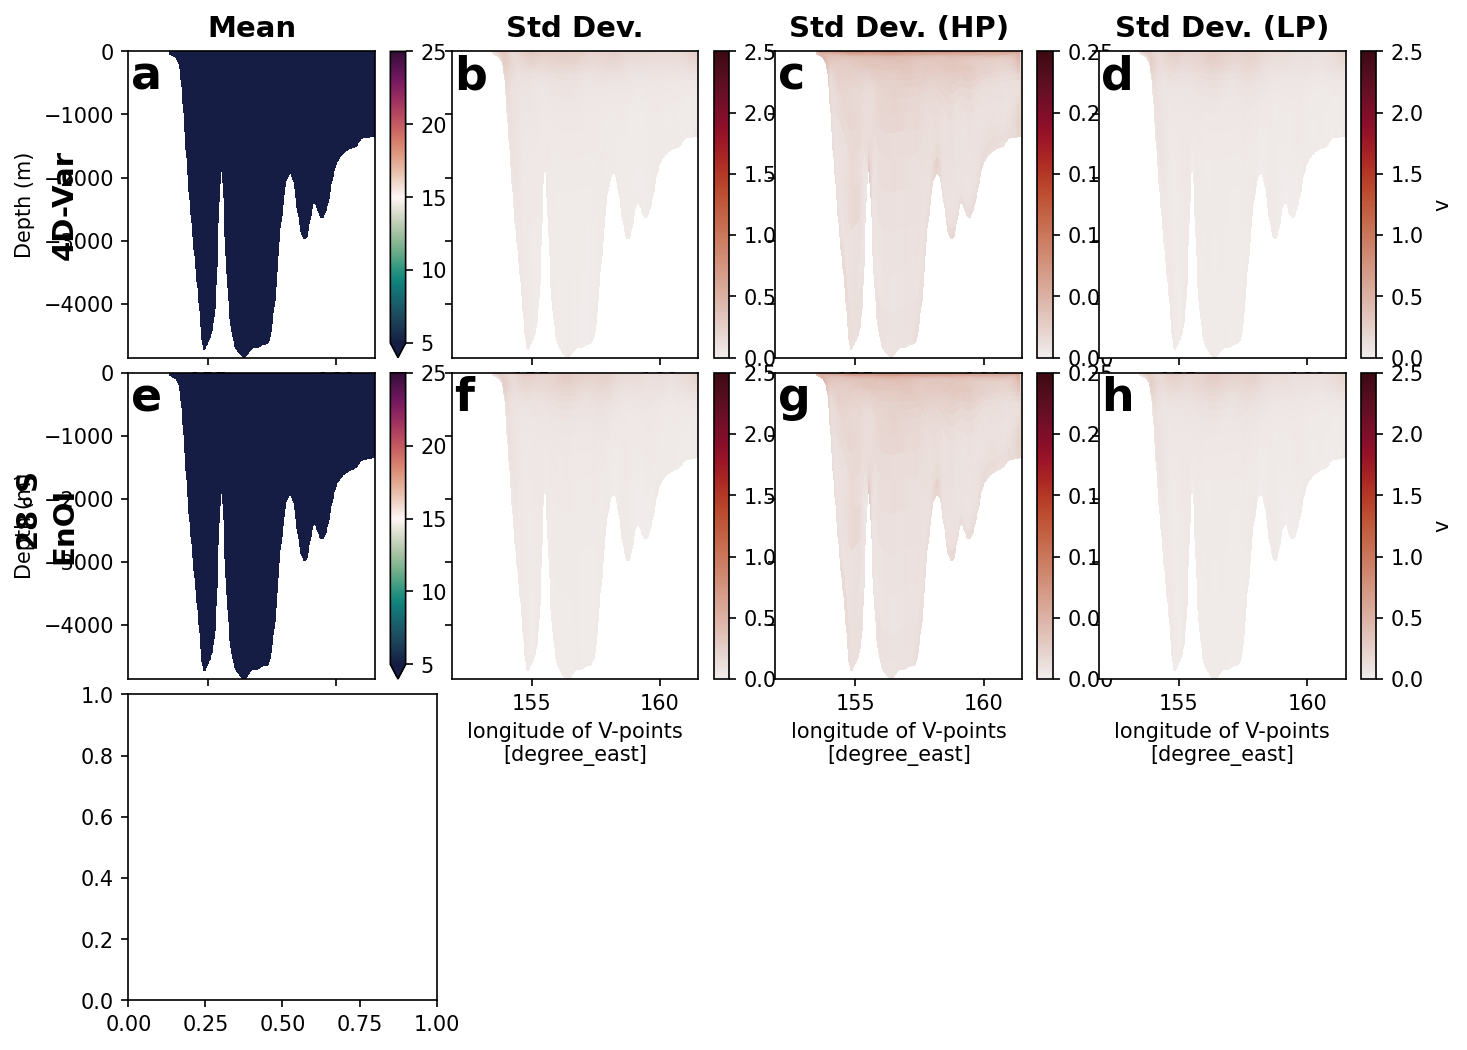

In [57]:



def addSubplot_spatialMap(input,pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_v,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.set_title('')
    return gl,im



def addInsetColormap(ax,im,lab):
    cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax) 
    cbar.set_label(lab)


# gs to make a 4 row, 7 col plot

plt.cla()
plt.clf()
fig = plt.figure(figsize=[11,11],dpi=150)
ax = None

gs = fig.add_gridspec(nrows=4,ncols=4,wspace=0.05, hspace=0.05)

# gs00 = gs0[0].subgridspec(2, 2,wspace=0.05, hspace=0.05)
# gs01 = gs0[1].subgridspec(1, 1)

cax_mn = (2,20)
cax_std = (0,1)
cax_std_hp = (0,1)
cax_std_lp = (0,1)


###############
ax = fig.add_subplot(gs[0,0])
_4dvar_28.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=5,vmax=25)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.4, -.5, '28$\circ$S',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(-.26, .5, '4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,1])
_4dvar_28.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=2.5)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax = fig.add_subplot(gs[0,2])
_4dvar_28_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=.25)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,3])
_4dvar_28_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=2.5)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)





###############
ax = fig.add_subplot(gs[1,0])
enoi_28.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=5,vmax=25)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,1])
enoi_28.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=2.5)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax = fig.add_subplot(gs[1,2])
enoi_28_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=.25)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,3])
enoi_28_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=2.5)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)



###############
ax = fig.add_subplot(gs[2,0])
(_4dvar_28.v.mean(dim='ocean_time')-enoi_28.temp.mean(dim='ocean_time')).plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-2,vmax=2)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.26, .5, '4DVar-EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[2,1])
(_4dvar_28.v.std(dim='ocean_time')-enoi_28.temp.std(dim='ocean_time')).plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-0.1,vmax=.1)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


ax = fig.add_subplot(gs[2,2])
(_4dvar_28_hp.std(dim='ocean_time')-enoi_28_hp.std(dim='ocean_time')).plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-0.1,vmax=.1)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[2,3])
(_4dvar_28_lp.std(dim='ocean_time')-enoi_28_lp.std(dim='ocean_time')).plot(x='lon_v',y='z_v0',cmap='cmo.balance',vmin=-.1,vmax=.1)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)


##############
ax = fig.add_subplot(gs[3,0])
_4dvar_34.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=5,vmax=25)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.text(0.01, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.4, -.5, '34$\circ$S',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(-.26, .5, '4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[3,1])
_4dvar_34.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=2.5)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[3,2])
_4dvar_34_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=.25)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'k', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[3,3])
_4dvar_34_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=2.5)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'l', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)







##############
ax = fig.add_subplot(gs[4,0])
enoi_34.v.mean(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=5,vmax=25)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.text(0.01, 0.99, 'm', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[4,1])
enoi_34.v.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=2.5)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'n', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[4,2])
enoi_34_hp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=.25)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'o', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[4,3])
enoi_34_lp.std(dim='ocean_time').plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=2.5)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'p', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)



##############
ax = fig.add_subplot(gs[5,0])
(_4dvar_34.v.mean(dim='ocean_time')-enoi_34.temp.mean(dim='ocean_time')).plot(x='lon_v',y='z_v0',cmap='cmo.curl',vmin=5,vmax=25)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('Depth (m)')
ax.text(0.01, 0.99, 'm', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Mean',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[5,1])
(_4dvar_34.v.std(dim='ocean_time')-enoi_34.temp.std(dim='ocean_time')).plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=2.5)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'n', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev.',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[5,2])
(_4dvar_34_hp.std(dim='ocean_time')-enoi_34_hp.std(dim='ocean_time')).plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=.25)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'o', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (HP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)

ax = fig.add_subplot(gs[5,3])
(_4dvar_34_lp.std(dim='ocean_time')-enoi_34_lp.std(dim='ocean_time')).plot(x='lon_v',y='z_v0',cmap='cmo.amp',vmin=0,vmax=2.5)#,pcol_kwargs={'cmap':'cmo.balance','vmin':-1e-4*scaling,'vmax':1e-4*scaling})
ax.set_ylabel('')
ax.set_yticklabels([])
ax.text(0.01, 0.99, 'p', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'Std Dev. (LP)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
# ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)





In [ ]:
STOP

In [ ]:
u_bar = grid.interp(enoi.u.mean("ocean_time"),'X')
v_bar = grid.interp(enoi.v.mean("ocean_time"),'Y')
mke = 0.5*(u_bar**2 + v_bar**2)

enoi["mke"] = mke

In [ ]:

enoi.mke.isel(s_rho=-1).plot()

In [ ]:
u_rho = grid.interp(enoi.u,'X')
v_rho = grid.interp(enoi.v,'Y')

print('calc velocity anomalies')
u_prime = u_rho - u_bar
v_prime = v_rho - v_bar

print('calc eke')
eke = 0.5*(u_prime**2 + v_prime**2)

# enoi["eke"] = eke

In [ ]:
eke.isel(s_rho=-1).mean(dim='ocean_time').plot()

In [ ]:
eke_0_400=grid.average(eke.where(enoi.z_rho>-400),'Z')
# eke_0_400=grid.average(eke.where(enoi.z_rho>-400),'Z')
mke_0_400=mke.where(enoi.z_rho0>-400).weighted(weights=enoi.dz.mean(dim='ocean_time')).mean(dim='s_rho')

eke_400_1200=grid.average(eke.where((enoi.z_rho<-400)&(enoi.z_rho>-1200)),'Z')
# mke_400_1200=grid.average(mke.where((enoi.z_rho0<-400)&(enoi.z_rho0>-1200)),'Z')
mke_400_1200=mke.where((enoi.z_rho0<-400)&(enoi.z_rho0>-1200)).weighted(weights=enoi.dz.mean(dim='ocean_time')).mean(dim='s_rho')

In [ ]:
eke_0_400.mean(dim='ocean_time').plot()

In [ ]:
(eke.where(enoi.z_rho>-400).weighted(weights=enoi.dz).mean(dim='s_rho').mean(dim='ocean_time')).plot()

#### Start plotting

In [ ]:
Coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
CoastHR = cfeature.GSHHSFeature(scale='auto')

In [ ]:



def addSubplot_spatialMap(input,Grid,pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(Grid.lon_rho,Grid.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.set_title('')
    return gl,im



# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[17,9])
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(mke_0_400,enoi)
# co = truth_eke_0.std(dim='ocean_time').plot.contour(ax=ax[0], x='lon_rho',y='lat_rho',levels=np.arange(0,0.4,0.1),colors='black',zorder=12, linewidths=0.5)
# ax[0].clabel(co, co.levels, inline=True, fontsize=10)
gl.left_labels = True
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(mke_400_1200,enoi)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(eke_0_400.mean(dim='ocean_time'),enoi)
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax = fig.add_subplot(gs[0,3], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(eke_400_1200.mean(dim='ocean_time'),enoi)
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

# ax.text(-.26, .5, 'EKE (0 m) & RMSE',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.5, 1.12, 'Ref state',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
